# 1. Préparation du jeu de données

## a) Chargement des fichiers utiles
* Connexion au drive Google

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


* Nous utilisons le GPU permettant une meilleure exécution des modèles

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 7.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619409 sha256=dff79d3906972727525463963acafbd7bbce6182c6298dbe4cb20d04cb42589f
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


* Chargement des fichiers **d'articles** et de **clicks** des utilisateurs en DataFrame 

In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno
import warnings

from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import kernel_ridge
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from surprise import Reader, Dataset
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNBaseline
from surprise import KNNWithZScore
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise import SVD, accuracy
from surprise.model_selection import cross_validate

from tensorflow.python.keras import backend as K


import _pickle as cPickle
import pickle
from random import randint
from scipy.spatial import distance

warnings.filterwarnings('ignore')

sns.set()

missing_values = ["na", "n/a", "--", " "]
data_art_df = pd.read_csv("/content/drive/MyDrive/sample data/articles_metadata.csv",
                         sep=',', na_values=missing_values,
                         low_memory=False)

data_click_df = pd.read_csv("/content/drive/MyDrive/sample data/clicks.csv",
                         sep=',', na_values=missing_values,
                         low_memory=False)

data_click_df_s = pd.read_csv("/content/drive/MyDrive/sample data/clicks_sample.csv",
                         sep=',', na_values=missing_values,
                         low_memory=False)

## b) Contenu des fichiers


* Fichier des articles


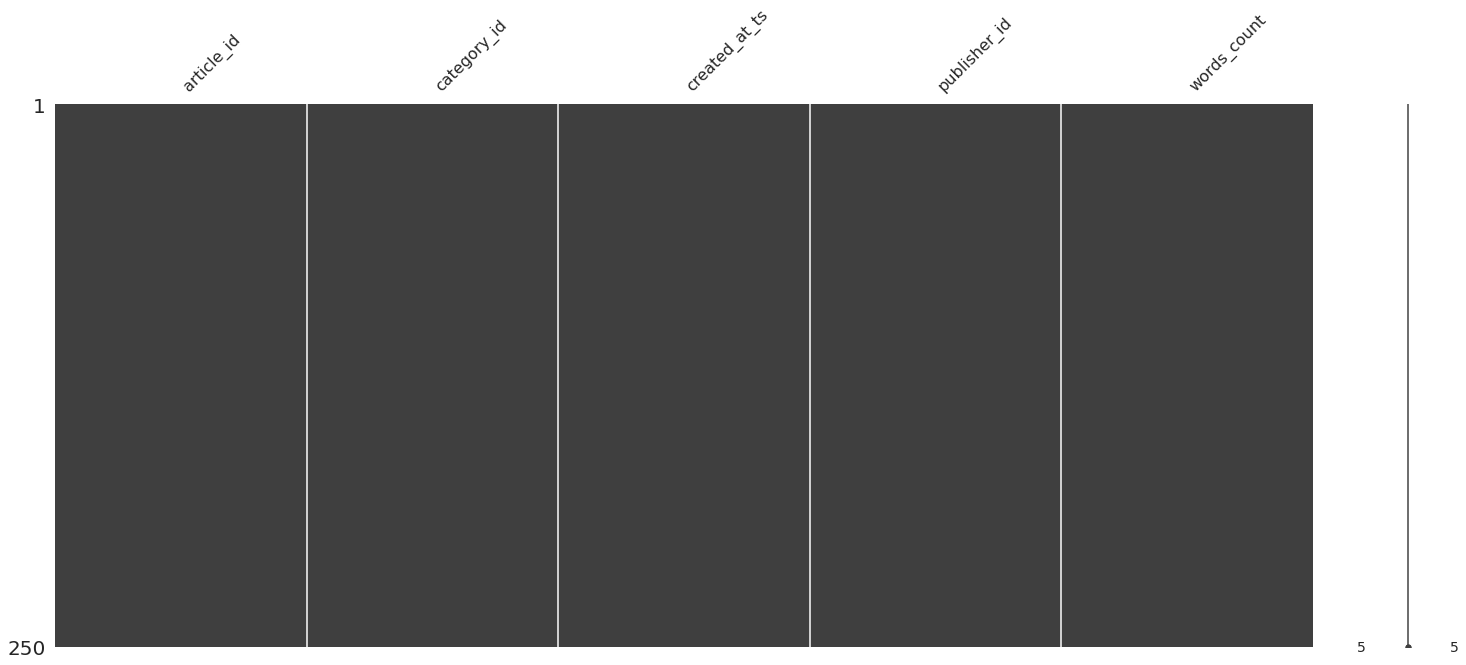

In [ ]:
msno.matrix(data_art_df.sample(250))

In [ ]:
data_art_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB


In [ ]:
print(data_art_df.shape)
data_art_df.head()

(364047, 5)


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


* Fichier des clicks des utilisateurs

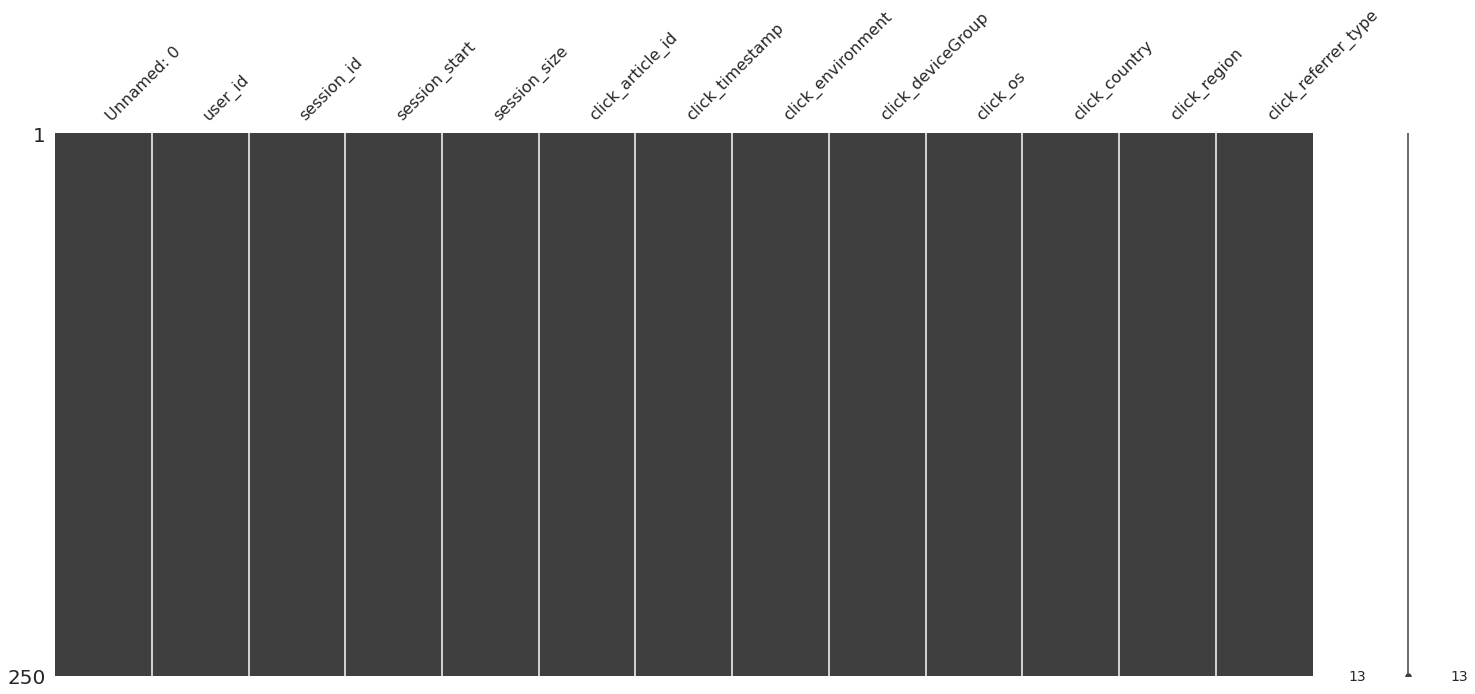

In [ ]:
msno.matrix(data_click_df.sample(250))

In [ ]:
data_click_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 13 columns):
 #   Column               Dtype
---  ------               -----
 0   Unnamed: 0           int64
 1   user_id              int64
 2   session_id           int64
 3   session_start        int64
 4   session_size         int64
 5   click_article_id     int64
 6   click_timestamp      int64
 7   click_environment    int64
 8   click_deviceGroup    int64
 9   click_os             int64
 10  click_country        int64
 11  click_region         int64
 12  click_referrer_type  int64
dtypes: int64(13)
memory usage: 296.4 MB


In [ ]:
print(data_click_df.shape)
data_click_df.head(10)

(2988181, 13)


,Unnamed: 0,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
5,5,2,1506825435299739,1506825435000,2,30970,1506827120575,4,1,17,1,24,2
6,6,3,1506825442704740,1506825442000,2,236065,1506827536942,4,3,2,1,21,1
7,7,3,1506825442704740,1506825442000,2,236294,1506827566942,4,3,2,1,21,1
8,8,4,1506825528135741,1506825528000,2,48915,1506826927593,4,1,17,1,17,1
9,9,4,1506825528135741,1506825528000,2,44488,1506826957593,4,1,17,1,17,1


> <font color='red'> Les fichiers des articles et des clicks ne contiennent pas de cellules vides. </font>

In [ ]:
df = data_click_df.merge(data_art_df, left_on='click_article_id', right_on='article_id')
df = df[['user_id', 'article_id', 'category_id']]
df

,user_id,article_id,category_id
0,0,157541,281
1,20,157541,281
2,44,157541,281
3,45,157541,281
4,76,157541,281
...,...,...,...
2988176,195186,2221,1
2988177,75658,271117,399
2988178,217129,20204,9
2988179,217129,70196,136


* Création de la matrice user-rating

In [ ]:
series = df.groupby(['user_id', 'category_id']).size()

user_rating = series.to_frame()
user_rating = user_rating.reset_index()
user_rating.rename(columns = {0:'rating'}, inplace = True)
user_rating

,user_id,category_id,rating
0,0,136,1
1,0,186,2
2,0,209,1
3,0,281,2
4,0,375,1
...,...,...,...
1882297,322894,297,1
1882298,322895,133,1
1882299,322895,418,1
1882300,322896,26,1


In [ ]:
user_rating.rating.value_counts()

1      1378686
2       293327
3        97043
4        43989
5        23658
        ...   
103          1
104          1
107          1
109          1
64           1
Name: rating, Length: 127, dtype: int64

* Création de la matrice **user_rating_s** pour le **fichier sample**

In [ ]:
df_s = data_click_df_s.merge(data_art_df, left_on='click_article_id', right_on='article_id')
df_s = df_s[['user_id', 'article_id', 'category_id']]
df_s

,user_id,article_id,category_id
0,0,157541,281
1,20,157541,281
2,44,157541,281
3,45,157541,281
4,76,157541,281
...,...,...,...
1878,681,260988,395
1879,696,355863,448
1880,703,84094,174
1881,703,83472,174


In [ ]:
series = df_s.groupby(['user_id', 'category_id']).size()

user_rating_s = series.to_frame()
user_rating_s = user_rating_s.reset_index()
user_rating_s.rename(columns = {0:'rating'}, inplace = True)
user_rating_s

,user_id,category_id,rating
0,0,136,1
1,0,281,1
2,1,209,1
3,1,375,1
4,2,26,1
...,...,...,...
1707,705,247,1
1708,705,412,1
1709,706,136,1
1710,706,209,1


In [ ]:
user_rating_enough_s = user_rating_s.loc[user_rating_s.rating > 1]
reader = Reader()
data_s = Dataset.load_from_df(user_rating_enough_s[['user_id', 'category_id', 'rating']], reader)

trainset_s, testset_s = train_test_split(data_s, test_size=0.25)

* Jeu de données pour la librairie **Implicit**

In [ ]:
from sklearn.model_selection import train_test_split

train, cros_val = train_test_split(df, test_size = 0.2)

In [ ]:
print('Splitted dataset into train set, cross validation set')
print('Train shape:', train.shape)
print('cros_val shape:', cros_val.shape)

Splitted dataset into train set, cross validation set
Train shape: (2390544, 3)
cros_val shape: (597637, 3)


# 2. Content-Based Filtering Model

> Le **filtrage basé sur le contenu** exploite la description des articles avec lesquels l’utilisateur a interagis afin sz recommander des articles similaires. Cela ne dépend que des choix précédents de l’utilisateur, ce qui rend cette méthode robuste pour éviter le problème de démarrage à froid. On peut ainsi créer des profils d’ articles et des profils utilisateur.

> La méthode **TF-IDF** est la plus couramment utilisée pour convertir l' article en une structure vectorielle, où chaque mot est représenté par une position dans le vecteur, et la valeur mesure la pertinence d’un mot donné dans cet article.
 Comme tous les éléments seront représentés dans le même modèle d’espace vectoriel, il s’agit de calculer la similitude entre les articles par le **cosinus de l'angle** entre les différents vecteurs.



* Chargement la matrice **embedding** des articles 

In [ ]:
with open(r"/content/drive/MyDrive/sample data/articles_embeddings.pickle", "rb") as input_file:
    e = cPickle.load(input_file)

e.shape

(364047, 250)

* Fonction de récupération de **n articles similaires** pour un utilisateur (**par user_id**)

In [ ]:
def getnArticles(e, n, userId):
    
    ee = e
    
    # get all articles read by user
    var = data_click_df.loc[data_click_df['user_id']==userId]['click_article_id'].tolist()
    
    # chose randomly one
    value = randint(0, len(var))
    
    # delete all read articles except the selected one( we do not want to offer
    # user to read something he already read)
    for i in range(0, len(var)):
        if i != value:
            ee = np.delete(ee, [i], 0)
    
    arr = []
    
    # delete selected article in the new matrix
    f = np.delete(ee, [value], 0)
    
    # get n articles the most similar to the selected one
    for i in range(0, n):
        distances = distance.cdist([ee[value]], f, "cosine")[0]
        min_index = np.argmin(distances)
        f = np.delete(f, [min_index], 0)
    # find corresponding matrix in original martix
        result = np.where(e==f[min_index])
        arr.append(result[0][0])
        
    return arr

getnArticles(e, 10, 0)

[25, 462, 423, 1473, 1419, 588, 473, 958, 576, 693]

> <font color='red'> Voici la liste des 10 articles similaires lus et vus par l'utilisateur 0. </font>

* On peut ajouter **le nombre de mots** de chaque article dans la matrice **embedding**

In [ ]:
d = e
max = data_art_df['words_count'].max()
data_art_df['words_count'] = data_art_df['words_count'].apply(lambda x: x/max)

d = np.append(d, np.reshape(data_art_df['words_count'].to_numpy(),
                            newshape=(data_art_df['words_count'].shape[0], 1)),
              axis=1)

d.shape

(364047, 251)

In [ ]:
getnArticles(d, 10, 0)

[11, 671, 86, 433, 28, 1424, 139, 413, 983, 1]

> <font color='red'> Voici la liste des 10 articles similaires lus et vus par l'utilisateur 0 lorsqu'on ajoute la donnée **words_count**. </font>


> <font color='red'> Dans la recommandation par le contenu, nous avons proposé parmi tous les articles, ceux qui sont similaires aux articles sur lesquels l'utilisateur a cliqués. </font>

# 3. Collaborative Filtering Model

> Le **filtrage basé sur la collaboration** fait des prédictions automatiques (filtrage) sur les intérêts d’un utilisateur en collectant les préférences ou les informations de goût de nombreux utilisateurs (collaboration). L’hypothèse sous-jacente de l’approche de filtrage collaboratif est que si une personne A a la même opinion qu’une personne B sur un ensemble d’éléments, A est plus susceptible d’avoir l’opinion de B pour un élément donné que celle d’une personne choisie au hasard.

> On a 2 approches d'implémentation du **Collaborative Filtering**:

* une basée sur la mémoire : cette approche utilise la mémoire des interactions des utilisateurs précédents pour calculer les similitudes des utilisateurs en fonction des éléments avec lesquels ils ont interagis (approche basée sur l’utilisateur) ou calculer les similitudes des éléments en fonction des utilisateurs qui ont interagi avec eux (approche basée sur les éléments).

* basé sur un modèle : les modèles sont développés à l’aide de différents algorithmes d’apprentissage automatique pour recommander des éléments aux utilisateurs. Il existe de nombreux algorithmes CF basés sur des modèles, tels que les réseaux de neurones, les réseaux bayésiens, les modèles de clustering et les modèles de facteurs latents tels que la décomposition de valeur singulière (SVD) et l’analyse sémantique latente probabiliste


## Création d'un rating pour chaque catégorie d'article vue par chaque utilisateur

In [ ]:
K.clear_session()

In [ ]:
user_rating_enough = user_rating.loc[user_rating.rating > 5]
print('On a sélectionné ', len(user_rating_enough), ' interactions.')

On a sélectionné  45599  interactions.


In [ ]:
from surprise.model_selection import train_test_split

reader = Reader()
data = Dataset.load_from_df(user_rating_enough[['user_id', 'category_id', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.25)
print('Test set lenght :', len(testset))
print('Train set lenght :', len(user_rating_enough) - len(testset))

Test set lenght : 11400
Train set lenght : 34199


## Première approche avec **k-NN** et optimisation des paramètres du modèle

* Entrainement du modèle et recherche des paramètres optimaux

In [ ]:
from surprise import KNNWithMeans

sim_options = {
    "name": ["cosine"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options, "k": [5, 10], "min_k": [2, 3]}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(data)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

* Performance du modèle **KNNWithMeans**

In [ ]:
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

9.04694921100913
{'sim_options': {'name': 'cosine', 'min_support': 5, 'user_based': False}, 'k': 10, 'min_k': 3}


In [ ]:
algo_knn = KNNWithMeans(k=10, min_k=3)
algo_knn.fit(trainset)

cross_validate(algo_knn, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    10.3729 8.5198  8.1432  9.0120  0.9745  
MAE (testset)     4.7079  4.6061  4.5105  4.6082  0.0806  
Fit time          23.80   23.40   22.17   23.12   0.69    
Test time         11.75   12.05   12.14   11.98   0.16    


{'fit_time': (23.796727895736694, 23.39501667022705, 22.17151403427124),
 'test_mae': array([4.7078935 , 4.60612373, 4.5104795 ]),
 'test_rmse': array([10.37288533,  8.5198167 ,  8.14321407]),
 'test_time': (11.754831314086914, 12.050522089004517, 12.14085054397583)}

In [ ]:
predictions_knn = algo_knn.test(testset)
accuracy.rmse(predictions_knn)

RMSE: 8.4328


8.432820123873519

* Sauvegarde du modèle et récupération du top 10 des articles pour chaque utilisateur

In [ ]:
from collections import defaultdict


def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n



In [ ]:
top_10_knn = get_top_n(predictions_knn, n=10)

with open("top_10_knn.txt", "wb") as fp:
    pickle.dump(top_10_knn, fp)

file_model = open('algo_knn.pickle', 'wb')
pickle.dump(algo_knn, file_model)
file_model.close()

## Deuxième approche avec **SVD** et optimisation des paramètres du modèle

> Il s'agit d'un algorithme de factorisation de matrice les plus utilisés. L'algorithme **SVD** est efficace car il permet de trouver des variables latentes qui lient les utilisateurs et les articles

* Entrainement du modèle et recherche des paramètres optimaux

In [ ]:
param_grid = {"n_epochs": [5, 10],
              "lr_all": [0.002, 0.005],
              "reg_all": [0.4, 0.6]
}

gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

gs.fit(data)

* Performance du modèle **SVD**

In [ ]:
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

9.02624979339465
{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.4}


In [ ]:
algo_svd = SVD()
algo_svd.fit(trainset)

cross_validate(algo_svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    9.7908  8.5266  8.7991  9.0388  0.5433  
MAE (testset)     4.6473  4.5686  4.5654  4.5938  0.0379  
Fit time          1.52    1.47    1.49    1.49    0.02    
Test time         0.10    0.09    0.10    0.10    0.00    


{'fit_time': (1.5248782634735107, 1.4735164642333984, 1.486208200454712),
 'test_mae': array([4.64730263, 4.56855263, 4.56543194]),
 'test_rmse': array([9.79084226, 8.52660696, 8.79905581]),
 'test_time': (0.09808540344238281, 0.09408044815063477, 0.09716606140136719)}

In [ ]:
predictions_svd = algo_svd.test(testset)
accuracy.rmse(predictions_svd)

RMSE: 8.4208


8.420771102750168

* Sauvegarde du modèle et récupération du top 10 des articles pour chaque utilisateur

In [ ]:
top_10_svd = get_top_n(predictions_svd, n=10)

with open("top_10_svd.txt", "wb") as fp:
    pickle.dump(top_10_svd, fp)

file_model = open('algo_svd.pickle', 'wb')
pickle.dump(algo_svd, file_model)
file_model.close()

# 4. Librairie **Implicit**


In [ ]:
!pip install implicit

     |████████████████████████████████| 1.1 MB 7.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for implicit: filename=implicit-0.4.8-cp37-cp37m-linux_x86_64.whl size=4606631 sha256=cdf7cd4877385c078b8e736e13800b1e9c0703436c79bb141e74399ea49e0e89
  Stored in directory: /root/.cache/pip/wheels/88/e6/34/25e73cccbaf1a961154bb562a5f86123b68fdbf40e306073d6
Successfully built implicit


> L'algorithme **AlternatingLeastSquares** permet la factorisation de matrice dans le cas du Collaborative Filtering implicite.

In [ ]:
import scipy.sparse as sparse
import implicit

user_categories = sparse.csr_matrix((user_rating_enough['rating'].astype(float),
                                   (user_rating_enough['user_id'],
                                    user_rating_enough['category_id'])))
category_users = sparse.csr_matrix((user_rating_enough['rating'].astype(float),
                                (user_rating_enough['category_id'],
                                 user_rating_enough['user_id'])))

alpha = 40
train_c = (category_users*alpha).astype('double')

In [ ]:
model = implicit.als.AlternatingLeastSquares(factors=500, iterations=10)

model.fit(train_c)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
import csv

fields = 'user_id', 'article_list'
filename = 'rec_train.csv'

with open (filename, 'a', newline = '') as f:
    writer = csv.writer(f)
    writer.writerow(fields)
    userId = user_rating_enough['user_id'].values.tolist()
    for user in userId:
        scores = []
        items = []
        results = []
        results.append(user)
        recommendations = model.recommend(user, user_categories, N = 5)
        for item in recommendations:
            ids, score = item
            scores.append(score)
            items.append(ids)
        results.append(items)
        writer.writerow(results)



* Performance :

In [ ]:
!pip install ml_metrics

  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-py3-none-any.whl size=7845 sha256=e00373b4a68b0af11c390df7457818f1ebba0024d4a9a74578ef34bd5ddd3177
  Stored in directory: /root/.cache/pip/wheels/56/41/5b/0c6d42b3604a5c823d8922564c4708f84962fa7f2f4facfa6d
Successfully built ml-metrics


In [ ]:
import ast
import numpy as np
import ml_metrics

predicted = pd.read_csv('rec_train.csv')
predicted = predicted['article_list']
predicted = [ast.literal_eval(a) for a in predicted]
actual = train['article_id']
actual = np.array(actual).reshape(2390544, 1)
score = ml_metrics.mapk(actual, predicted, 5)

print('Mean avg. precision at k for train set:','{:.10f}'.format(score))

Mean avg. precision at k for train set: 0.0000000000


# 5. Feature Engineering

* Corrélation entre les variables de **data_click_df**

In [ ]:
data_click_df.corr()

,Unnamed: 0,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
Unnamed: 0,1.000000,0.309581,0.995470,0.995470,0.010596,0.053229,0.994440,-0.007726,0.028084,-0.027354,-0.005753,-0.001063,-0.008196
user_id,0.309581,1.000000,0.298914,0.298914,-0.120516,0.002783,0.298206,0.010154,-0.001164,-0.035183,-0.025436,-0.019286,0.061559
session_id,0.995470,0.298914,1.000000,1.000000,0.010378,0.050934,0.999008,-0.008273,0.027373,-0.026146,-0.005614,-0.000637,-0.008510
session_start,0.995470,0.298914,1.000000,1.000000,0.010378,0.050934,0.999008,-0.008273,0.027373,-0.026146,-0.005614,-0.000637,-0.008510
session_size,0.010596,-0.120516,0.010378,0.010378,1.000000,-0.021707,0.017478,0.026922,-0.133212,0.094333,-0.003967,-0.010164,-0.091380
click_article_id,0.053229,0.002783,0.050934,0.050934,-0.021707,1.000000,0.050767,0.004754,0.011653,-0.006055,-0.006718,0.114236,0.007195
click_timestamp,0.994440,0.298206,0.999008,0.999008,0.017478,0.050767,1.000000,-0.007613,0.024373,-0.024099,-0.005550,-0.000627,-0.008444
click_environment,-0.007726,0.010154,-0.008273,-0.008273,0.026922,0.004754,-0.007613,1.000000,-0.276354,0.077306,-0.044567,-0.029518,-0.045122
click_deviceGroup,0.028084,-0.001164,0.027373,0.027373,-0.133212,0.011653,0.024373,-0.276354,1.000000,-0.610782,0.087921,0.038088,0.038785
click_os,-0.027354,-0.035183,-0.026146,-0.026146,0.094333,-0.006055,-0.024099,0.077306,-0.610782,1.000000,0.038409,0.016910,-0.018690


> Observons plus particulièrement les corrélations entre la colonne **user_id** et les autres colonnes sachnat qu'on définit le degré de corrélation suivant l'échelle ci-dessous :

  * 0.00-0.19 “très faible”
  *  0.20-0.39 “faible”
  * 0.40-0.59 “modéré”
  * 0.60-0.79 “fort”
  * 0.80-1.00 “ très fort”

In [ ]:
correlations = data_click_df.corr()['user_id'].sort_values()

print('Fortes corrélations positives:\n', correlations.tail(15))
print('\nFortes corrélations négatives:\n', correlations.head(15))

Fortes corrélations positives:
 session_size          -0.120516
click_os              -0.035183
click_country         -0.025436
click_region          -0.019286
click_deviceGroup     -0.001164
click_article_id       0.002783
click_environment      0.010154
click_referrer_type    0.061559
click_timestamp        0.298206
session_start          0.298914
session_id             0.298914
Unnamed: 0             0.309581
user_id                1.000000
Name: user_id, dtype: float64

Fortes corrélations négatives:
 session_size          -0.120516
click_os              -0.035183
click_country         -0.025436
click_region          -0.019286
click_deviceGroup     -0.001164
click_article_id       0.002783
click_environment      0.010154
click_referrer_type    0.061559
click_timestamp        0.298206
session_start          0.298914
session_id             0.298914
Unnamed: 0             0.309581
user_id                1.000000
Name: user_id, dtype: float64


> <font color='red'> Il y a de très faibles corrélations cependant les variables **session_id et session_start** sont les plus correlées positivement à **user_id** mais négativement si on prend leurs valeurs absolues.
 De plus, **click_article_id, click_referrer_type, click_timestamp** sont les plus correlés négativement à **user_id.**</font>

* Affichage d'un heatmap pour la visualisation des corrélations avec user_id

In [ ]:
ext_data = data_click_df[['user_id', 'click_article_id', 'session_size',
                          'session_id', 'session_start']]

ext_data_corrs = ext_data.corr()
ext_data_corrs

,user_id,click_article_id,session_size,session_id,session_start
user_id,1.000000,0.002783,-0.120516,0.298914,0.298914
click_article_id,0.002783,1.000000,-0.021707,0.050934,0.050934
session_size,-0.120516,-0.021707,1.000000,0.010378,0.010378
session_id,0.298914,0.050934,0.010378,1.000000,1.000000
session_start,0.298914,0.050934,0.010378,1.000000,1.000000


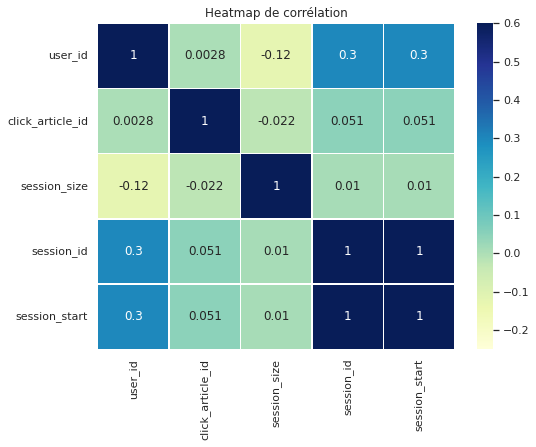

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(ext_data_corrs, cmap="YlGnBu",
            vmin=-0.25, annot=True, vmax=0.6, linewidths=.5)
plt.title('Heatmap de corrélation')
plt.show()

* Variables polynômiales

> Pour augmenter l'influence et la corrélation des variables **session_id et session_start** avec **user_id**,
  on va former de nouvelles variables qui sont des polynômes des variables initiales. 
  Dans notre cas, on va utiliser le degré d=3 afin d'obtenir de nouvelles variables qui sont le produit de l'interaction entre ces premières variables (**ex : session_id x session_start^2**).
> La classe **PolynomialFeatures** de **sklearn** permet de générer de telles variables polynômiales.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer


poly_features = data_click_df[['user_id', 'click_article_id', 'session_size',
                               'session_id', 'session_start']]

poly_user = poly_features['user_id']
poly_article = poly_features['click_article_id']


poly_features = poly_features.drop(columns=['user_id', 'click_article_id'])

poly_transformer = PolynomialFeatures(degree=3)
poly_transformer.fit(poly_features)

poly_features = poly_transformer.transform(poly_features)
print('Forme des variables polynômiales du fichier : ',
      poly_features.shape)

Forme des variables polynômiales du fichier :  (2988181, 20)


> <font color='green'> On est passé de 5 variables à 20 variables polynômiales de degré inférieures ou égales à 3.</font>

In [ ]:
poly_transformer.get_feature_names(input_features=['session_size',
                                                   'session_id',
                                                   'session_start'])[:20]

['1',
 'session_size',
 'session_id',
 'session_start',
 'session_size^2',
 'session_size session_id',
 'session_size session_start',
 'session_id^2',
 'session_id session_start',
 'session_start^2',
 'session_size^3',
 'session_size^2 session_id',
 'session_size^2 session_start',
 'session_size session_id^2',
 'session_size session_id session_start',
 'session_size session_start^2',
 'session_id^3',
 'session_id^2 session_start',
 'session_id session_start^2',
 'session_start^3']

In [ ]:
column_1 = poly_transformer.get_feature_names(['session_size',
                                               'session_id',
                                               'session_start'])

poly_features = pd.DataFrame(poly_features,
                             columns=column_1)

poly_features['user_id'] = poly_user
poly_features['click_article_id'] = poly_article


poly_corrs = poly_features.corr()['user_id'].sort_values()

print(poly_corrs.head(10))
print(poly_corrs.tail(5))

session_size                            -0.120516
session_size session_start              -0.120452
session_size session_id                 -0.120452
session_size session_start^2            -0.120388
session_size session_id session_start   -0.120388
session_size session_id^2               -0.120388
session_size^2                          -0.042910
session_size^2 session_start            -0.042903
session_size^2 session_id               -0.042903
session_size^3                          -0.016561
Name: user_id, dtype: float64
session_id^2     0.298898
session_start    0.298914
session_id       0.298914
user_id          1.000000
1                     NaN
Name: user_id, dtype: float64


In [ ]:
data_click_poly = pd.DataFrame(poly_features)

print('Forme du fichier train avec les var. polynômiales : ',
      data_click_poly.shape)

Forme du fichier train avec les var. polynômiales :  (2988181, 22)


In [ ]:
data = Dataset.load_from_df(data_click_poly[['user_id', 'click_article_id', 'session_size session_id']], reader)
gs.fit(data)

In [ ]:
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

8348322427522661.0
{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.4}


In [ ]:
cross_validate(algo_svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    8307794767713291.00008365020124849045.00008363493244284239.00008391483334904269.00008314278328844308.00008348413960119030.000032166071182490.1680
MAE (testset)     5881521337546082.00005880664052373838.00005890532973715627.00005882579992820841.00005874697592545580.00005881999189800394.00005069261430557.6865
Fit time          123.72  125.68  125.53  126.10  125.32  125.27  0.81    
Test time         7.01    8.04    7.02    6.94    6.96    7.19    0.42    


{'fit_time': (123.72462844848633,
  125.68379712104797,
  125.53120374679565,
  126.09755635261536,
  125.31898522377014),
 'test_mae': array([5.88152134e+15, 5.88066405e+15, 5.89053297e+15, 5.88257999e+15,
        5.87469759e+15]),
 'test_rmse': array([8.30779477e+15, 8.36502012e+15, 8.36349324e+15, 8.39148333e+15,
        8.31427833e+15]),
 'test_time': (7.005195617675781,
  8.040236711502075,
  7.016786336898804,
  6.936713933944702,
  6.964324235916138)}

# 6. Comparaison des différents modèles

On sauvegarde le modèle qui a le meilleur score de IoU de validation. Le score **Intersection over Union** sert à mésurer l'adéquation entre l'image segmentée et l'image réelle, elle est plus adapté pour la segmentation sémantique que ne peut l'être la précision.